In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from skmultilearn.problem_transform import BinaryRelevance

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [3]:
# Set random seed
random.seed(1337)

In [4]:
if not os.path.exists('../pickle_objs'):
    os.makedirs('../pickle_objs')

In [5]:
# Load train+validation data
X_train = pickle.load(open('../data/X_train.pkl','rb'))
y_train = pickle.load(open('../data/y_train.pkl','rb'))
X_val = pickle.load(open('../data/X_val.pkl','rb'))
y_val = pickle.load(open('../data/y_val.pkl','rb'))
X_test = pickle.load(open('../data/X_test.pkl','rb'))
y_test = pickle.load(open('../data/y_test.pkl','rb'))

X_train_val = pickle.load(open('../data/X_train_val.pkl','rb'))
y_train_val = pickle.load(open('../data/y_train_val.pkl','rb'))
# X_train_val = pickle.load(open('../data/X_train_val_os.pkl','rb'))
# y_train_val = pickle.load(open('../data/y_train_val_os.pkl','rb'))

In [6]:
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [7]:
# # Split data into train (0.8), validation (0.2), and test (0.2) sets
# X_train_val, X_test, y_train_val, y_test = train_test_split(data.drop(target_cols, axis=1), data[target_cols], test_size=0.2, random_state=1337)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1337)

In [8]:
X_train.head()

,id,comment_text
101689,202d64bd4c2bd9a4,champion hurdle delighted use 1 2_3 image uplo...
26429,4601831cd03ec679,edit war currently appear engage edit war note...
62499,a73c6f5b69d963be,-pron- wrong bud ready use taran boi verdict n...
10145,1ad558921b36c611,attempt change las vegas season las vegas augu...
16254,2adc0c27c1165eef,people arab homosexual bad thing d**n f***in h...


In [9]:
# Print value counts for train targets
for col in target_cols:
    print(y_train[col].value_counts())

0    86620
1     9122
Name: toxic, dtype: int64
0    94780
1      962
Name: severe_toxic, dtype: int64
0    90648
1     5094
Name: obscene, dtype: int64
0    95467
1      275
Name: threat, dtype: int64
0    90993
1     4749
Name: insult, dtype: int64
0    94878
1      864
Name: identity_hate, dtype: int64


In [10]:
# Print value counts for validation targets
for col in target_cols:
    print(y_val[col].value_counts())

0    28866
1     3048
Name: toxic, dtype: int64
0    31597
1      317
Name: severe_toxic, dtype: int64
0    30231
1     1683
Name: obscene, dtype: int64
0    31820
1       94
Name: threat, dtype: int64
0    30363
1     1551
Name: insult, dtype: int64
0    31648
1      266
Name: identity_hate, dtype: int64


In [11]:
# Print value counts for test targets
for col in target_cols:
    print(y_test[col].value_counts())

0    28791
1     3124
Name: toxic, dtype: int64
0    31599
1      316
Name: severe_toxic, dtype: int64
0    30243
1     1672
Name: obscene, dtype: int64
0    31806
1      109
Name: threat, dtype: int64
0    30338
1     1577
Name: insult, dtype: int64
0    31640
1      275
Name: identity_hate, dtype: int64


In [12]:
# Print value counts for train+validation targets
for col in target_cols:
    print(y_train_val[col].value_counts())

0    115486
1     12170
Name: toxic, dtype: int64
0    126377
1      1279
Name: severe_toxic, dtype: int64
0    120879
1      6777
Name: obscene, dtype: int64
0    127287
1       369
Name: threat, dtype: int64
0    121356
1      6300
Name: insult, dtype: int64
0    126526
1      1130
Name: identity_hate, dtype: int64


In [13]:
predicted = pd.DataFrame()
for col in target_cols:
    predicted[col] = [0]*y_test.shape[0]
predicted.head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [14]:
# Compute (trivially) ROC-AUC when predicting majority class
auc_average = []
for col in target_cols:
    fpr, tpr, threshold = roc_curve(y_test[col], predicted[col])
    auc_average.append(auc(fpr, tpr))
print('ROC-AUC When Predicting Majority Class (all zeros) =', np.mean(auc_average))

ROC-AUC When Predicting Majority Class (all zeros) = 0.5


In [15]:
num_feats = 1000
n_grams = 2
ngram_range = list(map(lambda x:x+1,range(n_grams)))

In [16]:
# Fit Count Vectorizer
if(os.path.isfile('../pickle_objs/countvec_{}_ngrams_{}.pkl'.format(num_feats,n_grams))):
    countvec = pickle.load(open('../pickle_objs/countvec_{}_ngrams_{}.pkl'.format(num_feats,n_grams), 'rb'))
else:
    countvec = CountVectorizer(analyzer='word', lowercase=True, max_features=num_feats,ngram_range=ngram_range)
    countvec.fit(X_train_val['comment_text'])
    pickle.dump(countvec,open('../pickle_objs/countvec_{}_ngrams_{}.pkl'.format(num_feats,n_grams),'wb'))

# Fit TF-IDF Vectorizer
if(os.path.isfile('../pickle_objs/tfidf_{}_ngrams_{}.pkl'.format(num_feats,n_grams))):
    tfidf = pickle.load(open('../pickle_objs/tfidf_{}_ngrams_{}.pkl'.format(num_feats,n_grams), 'rb'))
else:
    tfidf = TfidfVectorizer(analyzer='word', lowercase=True, max_features=1000,ngram_range=ngram_range)
    tfidf.fit(X_train_val['comment_text'])
    pickle.dump(tfidf,open('../pickle_objs/tfidf_{}_ngrams_{}.pkl'.format(num_feats,n_grams),'wb'))


In [17]:
# Transform data as per Count Vectorizer
X_train_val_countvec = countvec.transform(X_train_val['comment_text'])
X_test_countvec = countvec.transform(X_test['comment_text'])

# Transform data as per TF-IDF Vectorizer
X_train_val_tfidf = tfidf.transform(X_train_val['comment_text'])
X_test_tfidf = tfidf.transform(X_test['comment_text'])

In [18]:
# Fit individual BernoulliNB models for each target with Count Vectorizer
bnb_countvec = BinaryRelevance(BernoulliNB())
bnb_countvec.fit(X_train_val_countvec, y_train_val)
predictions_bnb_countvec = bnb_countvec.predict_proba(X_test_countvec)

# Fit individual GaussianNB models for each target with Count Vectorizer
gnb_countvec = BinaryRelevance(GaussianNB())
gnb_countvec.fit(X_train_val_countvec, y_train_val)
predictions_gnb_countvec = gnb_countvec.predict_proba(X_test_countvec)

# Fit individual GaussianNB models for each target with TF-IDF Vectorizer
gnb_tfidf = BinaryRelevance(GaussianNB())
gnb_tfidf.fit(X_train_val_tfidf, y_train_val)
predictions_gnb_tfidf = gnb_tfidf.predict_proba(X_test_tfidf)

# Fit individual Logistic Regression+l1 models for each target with TF-IDF Vectorizer
lr1_tfidf = BinaryRelevance(LogisticRegression(penalty='l1'))
lr1_tfidf.fit(X_train_val_tfidf, y_train_val)
predictions_lr1_tfidf = lr1_tfidf.predict_proba(X_test_tfidf)

# Fit individual Logistic Regression+l2 models for each target with TF-IDF Vectorizer
lr2_tfidf = BinaryRelevance(LogisticRegression(penalty='l2'))
lr2_tfidf.fit(X_train_val_tfidf, y_train_val)
predictions_lr2_tfidf = lr2_tfidf.predict_proba(X_test_tfidf)

# Fit RandomForestClassifier for each target with Count Vectorizer
rf_countvec = RandomForestClassifier(n_estimators=100)
rf_countvec.fit(X_train_val_countvec, y_train_val)
probabilities_rf_countvec = rf_countvec.predict_proba(X_test_countvec)

# Fit RandomForestClassifier for each target with TF-IDF Vectorizer
rf_tfidf = RandomForestClassifier(n_estimators=100)
rf_tfidf.fit(X_train_val_tfidf, y_train_val)
probabilities_rf_tfidf = rf_tfidf.predict_proba(X_test_tfidf)

# # Fit XGBClassifier for each target with Count Vectorizer
# xgb_countvec = BinaryRelevance(XGBClassifier(n_estimators=1))
# xgb_countvec.fit(X_train_val_countvec, y_train_val)
# predictions_xgb_countvec = xgb_countvec.predict_proba(X_test_countvec)

# # Fit XGBClassifier for each target with TF-IDF Vectorizer
# xgb_tfidf = BinaryRelevance(XGBClassifier(n_estimators=1))
# xgb_tfidf.fit(X_train_val_tfidf, y_train_val)
# predictions_xgb_tfidf = xgb_tfidf.predict_proba(X_test_tfidf)


# # Fit individual GaussianNB models for each target with TF-IDF Vectorizer
# scaler = preprocessing.StandardScaler().fit(X_train_val_tfidf)
# X_train_val_tfidf = scaler.transform(X_train_val_tfidf)
# X_test_tfidf = scaler.transform(X_test_tfidf)
# svc_tfidf = BinaryRelevance(SVC(kernel='linear'))
# svc_tfidf.fit(X_train_val_tfidf, y_train_val)
# predictions_svc_tfidf = svc_tfidf.predict_proba(X_test_tfidf)

In [21]:
# Predict probabilities of each class for Count Vectorizer (BernoulliNB)
probabilities_bnb_countvec = np.squeeze(np.asarray(predictions_bnb_countvec.todense()))

# Predict probabilities of each class for Count Vectorizer and TF-IDF Vectorizer (GaussianNB)
probabilities_gnb_countvec = np.squeeze(np.asarray(predictions_gnb_countvec.todense()))
probabilities_gnb_tfidf = np.squeeze(np.asarray(predictions_gnb_tfidf.todense()))


# Predict probabilities of each class for TF-IDF Vectorizer (LogisticRegression+l1)
probabilities_lr1_tfidf = np.squeeze(np.asarray(predictions_lr1_tfidf.todense()))

# Predict probabilities of each class for TF-IDF Vectorizer (LogisticRegression+l2)
probabilities_lr2_tfidf = np.squeeze(np.asarray(predictions_lr2_tfidf.todense()))

# # Predict probabilities of each class for TF-IDF Vectorizer (SVC(linear kernel))
# probabilities_svc_tfidf = np.squeeze(np.asarray(predictions_svc_tfidf.todense()))

In [28]:
probabilities_rf_tfidf

[array([[0.92, 0.08],
        [0.94, 0.06],
        [0.98, 0.02],
        ...,
        [1.  , 0.  ],
        [0.99, 0.01],
        [0.98, 0.02]]), array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]), array([[0.98, 0.02],
        [0.97, 0.03],
        [1.  , 0.  ],
        ...,
        [1.  , 0.  ],
        [0.99, 0.01],
        [1.  , 0.  ]]), array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]), array([[0.97, 0.03],
        [0.99, 0.01],
        [1.  , 0.  ],
        ...,
        [1.  , 0.  ],
        [1.  , 0.  ],
        [1.  , 0.  ]]), array([[1.  , 0.  ],
        [1.  , 0.  ],
        [0.99, 0.01],
        ...,
        [1.  , 0.  ],
        [1.  , 0.  ],
        [1.  , 0.  ]])]

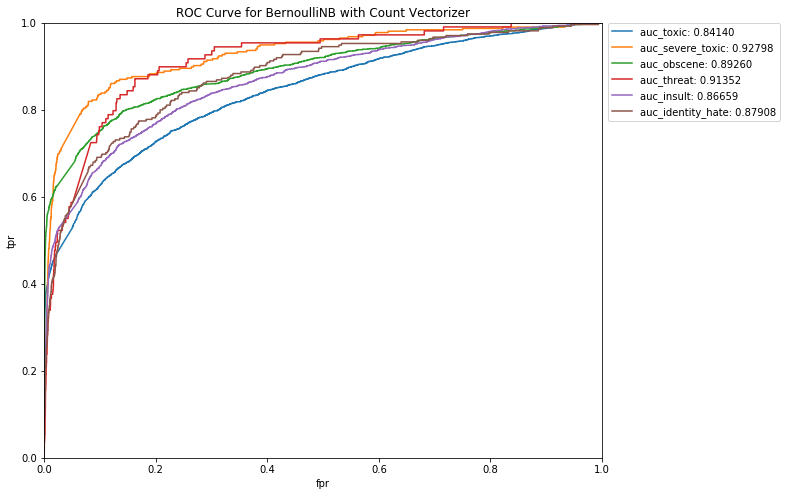

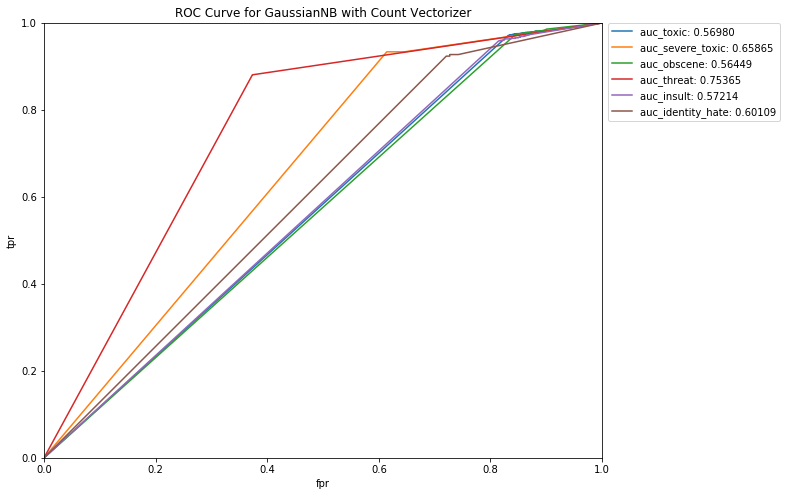

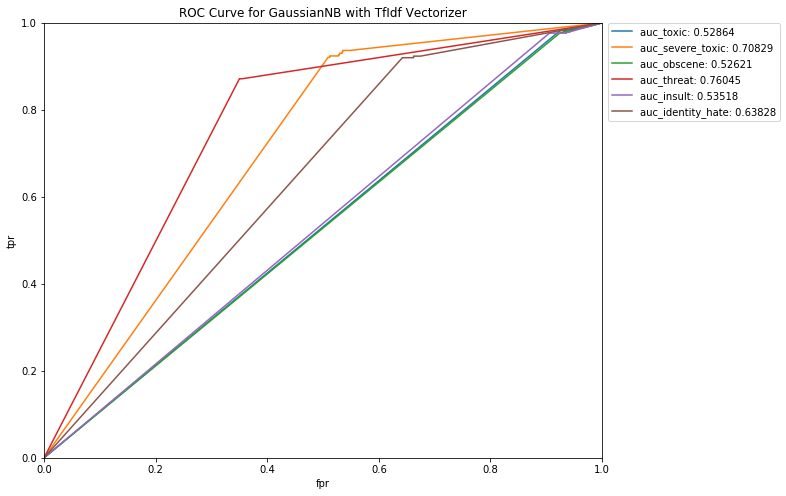

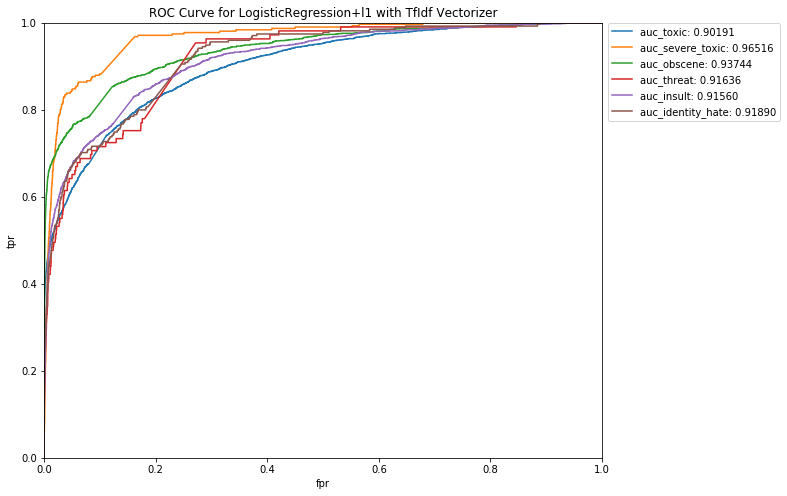

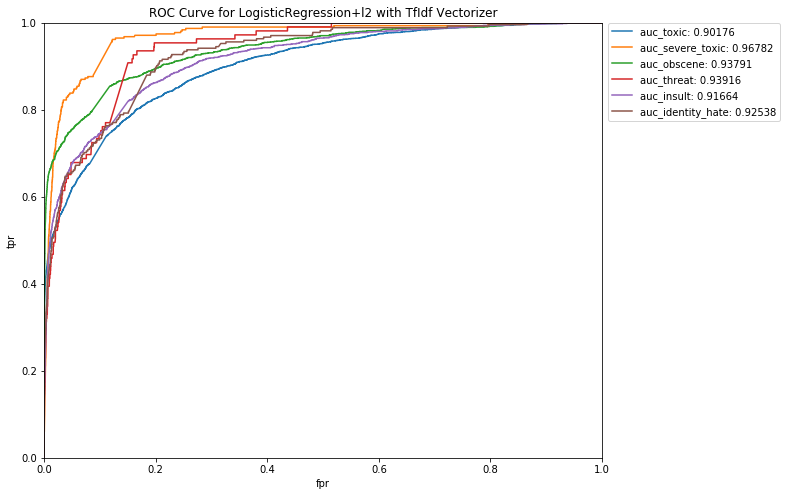

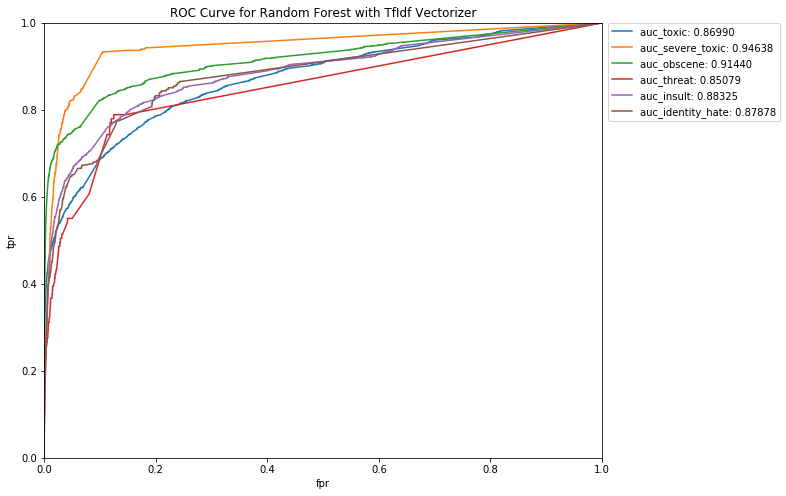

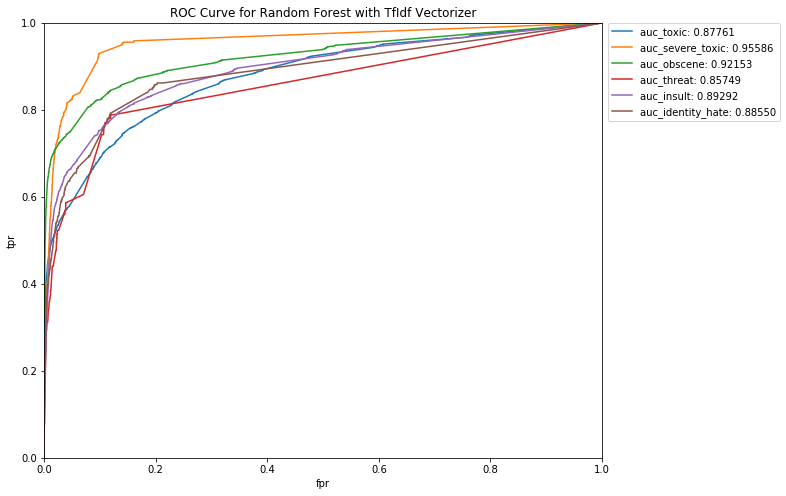

In [22]:
# Compute ROC-AUC values of each class for Count Vectorizer (BernoulliNB)
auc_bnb_countvec = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_bnb_countvec[:,i])
    auc_value = auc(fpr, tpr)
    auc_bnb_countvec.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for BernoulliNB with Count Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

# Compute ROC-AUC values of each class for Count Vectorizer (GaussianNB)
auc_gnb_countvec = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_gnb_countvec[:,i])
    auc_value = auc(fpr, tpr)
    auc_gnb_countvec.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for GaussianNB with Count Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

# Compute ROC-AUC values of each class for TfIdf Vectorizer (GaussianNB)
auc_gnb_tfidf = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_gnb_tfidf[:,i])
    auc_value = auc(fpr, tpr)
    auc_gnb_tfidf.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for GaussianNB with TfIdf Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

# Compute ROC-AUC values of each class for TfIdf Vectorizer (LogisticRegression+l1)
auc_lr1_tfidf = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_lr1_tfidf[:,i])
    auc_value = auc(fpr, tpr)
    auc_lr1_tfidf.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for LogisticRegression+l1 with TfIdf Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

# Compute ROC-AUC values of each class for TfIdf Vectorizer (LogisticRegression+l2)
auc_lr2_tfidf = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_lr2_tfidf[:,i])
    auc_value = auc(fpr, tpr)
    auc_lr2_tfidf.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for LogisticRegression+l2 with TfIdf Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

# Compute ROC-AUC values of each class for Count Vectorizer (RandomForestClassifier)
auc_rf_countvec = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_rf_countvec[i][:,1])
    auc_value = auc(fpr, tpr)
    auc_rf_countvec.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for Random Forest with TfIdf Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

# Compute ROC-AUC values of each class for TfIdf Vectorizer (RandomForestClassifier)
auc_rf_tfidf = []
plt.figure(figsize=(10,8))
for i, col in enumerate(target_cols):
    fpr, tpr, threshold = roc_curve(y_test[col], probabilities_rf_tfidf[i][:,1])
    auc_value = auc(fpr, tpr)
    auc_rf_tfidf.append(auc_value)
    plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for Random Forest with TfIdf Vectorizer')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

# # Compute ROC-AUC values of each class for Count Vectorizer (XGBClassifier)
# auc_xgb_countvec = []
# plt.figure(figsize=(10,8))
# for i, col in enumerate(target_cols):
#     fpr, tpr, threshold = roc_curve(y_test[col], probabilities_xgb_countvec[:,i])
#     auc_value = auc(fpr, tpr)
#     auc_xgb_countvec.append(auc_value)
#     plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
# plt.xlabel('fpr')
# plt.ylabel('tpr')
# plt.title('ROC Curve for XGBoost with Count Vectorizer')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# plt.show()

# # Compute ROC-AUC values of each class for TfIdf Vectorizer (XGBClassifier)
# auc_xgb_tfidf = []
# plt.figure(figsize=(10,8))
# for i, col in enumerate(target_cols):
#     fpr, tpr, threshold = roc_curve(y_test[col], probabilities_xgb_tfidf[:,i])
#     auc_value = auc(fpr, tpr)
#     auc_xgb_tfidf.append(auc_value)
#     plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
# plt.xlabel('fpr')
# plt.ylabel('tpr')
# plt.title('ROC Curve for XGBoost with TfIdf Vectorizer')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# plt.show()

# # Compute ROC-AUC values of each class for TfIdf Vectorizer (SVC(linear kernel))
# auc_svc_tfidf = []
# plt.figure(figsize=(10,8))
# for i, col in enumerate(target_cols):
#     fpr, tpr, threshold = roc_curve(y_test[col], probabilities_svc_tfidf[:,i])
#     auc_value = auc(fpr, tpr)
#     auc_svc_tfidf.append(auc_value)
#     plt.plot(fpr, tpr, label='{}: {:0.5f}'.format('auc_'+col, auc_value))
# plt.xlabel('fpr')
# plt.ylabel('tpr')
# plt.title('ROC Curve for LogisticRegression with TfIdf Vectorizer')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# plt.show()

In [23]:
# Get mean column-wise ROC-AUC values
print('ROC-AUC for BernoulliNB with Count Vectorizer = {:.4f}'.format(np.mean(auc_bnb_countvec)))
print('ROC-AUC for GaussianNB with TfIdf Vectorizer = {:.4f}'.format(np.mean(auc_gnb_tfidf)))
print('ROC-AUC for GaussianNB with Count Vectorizer = {:.4f}'.format(np.mean(auc_gnb_countvec)))
print('ROC-AUC for RandomForest with Count Vectorizer = {:.4f}'.format(np.mean(auc_rf_countvec)))
print('ROC-AUC for RandomForest with TfIdf Vectorizer = {:.4f}'.format(np.mean(auc_rf_tfidf)))
print('ROC-AUC for LogisticRegression+l1 with TfIdf Vectorizer = {:.4f}'.format(np.mean(auc_lr1_tfidf)))
print('ROC-AUC for LogisticRegression+l2 with TfIdf Vectorizer = {:.4f}'.format(np.mean(auc_lr2_tfidf)))
# print('ROC-AUC for XGBoost with Count Vectorizer = {:.4f}'.format(np.mean(auc_xgb_countvec)))
# print('ROC-AUC for XGBoost with TfIdf Vectorizer = {:.4f}'.format(np.mean(auc_xgb_tfidf)))
# print('ROC-AUC for SVC with TfIdf Vectorizer = {:.4f}'.format(np.mean(auc_svc_tfidf)))

ROC-AUC for BernoulliNB with Count Vectorizer = 0.8869
ROC-AUC for GaussianNB with TfIdf Vectorizer = 0.6162
ROC-AUC for GaussianNB with Count Vectorizer = 0.6200
ROC-AUC for RandomForest with Count Vectorizer = 0.8906
ROC-AUC for RandomForest with TfIdf Vectorizer = 0.8985
ROC-AUC for LogisticRegression+l1 with TfIdf Vectorizer = 0.9259
ROC-AUC for LogisticRegression+l2 with TfIdf Vectorizer = 0.9314


In [24]:
aucs = pd.DataFrame()
aucs['bnb_countvec'] = auc_bnb_countvec
aucs['gnb_tfidfvec'] = auc_gnb_tfidf
aucs['gnb_countvec'] = auc_gnb_countvec
aucs['rf_countvec'] = auc_rf_countvec
aucs['rf_tfidfvec'] = auc_rf_tfidf
aucs['lr1_tfidfvec'] = auc_lr1_tfidf
aucs['lr2_tfidfvec'] = auc_lr2_tfidf
# aucs['xgb_countvec'] = auc_xgb_countvec
# aucs['xgb_tfidfvec'] = auc_xgb_tfidf
# aucs['svc_tfidfvec'] = auc_svc_tfidf

aucs = aucs.T
aucs.columns = target_cols
aucs['mean'] = np.mean(aucs[target_cols], axis=1)
aucs

,toxic,severe_toxic,obscene,threat,insult,identity_hate,mean
bnb_countvec,0.841396,0.927984,0.892597,0.913520,0.866586,0.879078,0.886860
gnb_tfidfvec,0.528638,0.708291,0.526211,0.760447,0.535180,0.638276,0.616174
gnb_countvec,0.569800,0.658653,0.564489,0.753650,0.572142,0.601090,0.619971
rf_countvec,0.869897,0.946384,0.914404,0.850790,0.883251,0.878779,0.890584
rf_tfidfvec,0.877615,0.955857,0.921533,0.857488,0.892923,0.885504,0.898487
lr1_tfidfvec,0.901906,0.965163,0.937442,0.916361,0.915605,0.918895,0.925895
lr2_tfidfvec,0.901762,0.967820,0.937910,0.939157,0.916640,0.925375,0.931444
